In [1]:
import warnings; 
warnings.simplefilter('ignore')

## Install and Import Dependencies

In [2]:
!python -m pip install prophet


  Using cached prophet-1.1.2-py3-none-macosx_10_9_x86_64.whl (6.8 MB)
  Using cached cmdstanpy-1.1.0-py3-none-any.whl (83 kB)
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5


In [125]:
# Python
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy import stats


In [3]:
from prophet import Prophet

In [4]:
df = pd.read_csv('seattle-weather.csv')

In [5]:
df.describe()

,precipitation,temp_max,temp_min,wind
count,1461.000000,1461.000000,1461.000000,1461.000000
mean,3.029432,16.439083,8.234771,3.241136
std,6.680194,7.349758,5.023004,1.437825
min,0.000000,-1.600000,-7.100000,0.400000
25%,0.000000,10.600000,4.400000,2.200000
50%,0.000000,15.600000,8.300000,3.000000
75%,2.800000,22.200000,12.200000,4.000000
max,55.900000,35.600000,18.300000,9.500000


In [6]:
df.shape

(1461, 6)

In [7]:
df.isna().sum()

date             0
precipitation    0
temp_max         0
temp_min         0
wind             0
weather          0
dtype: int64

In [8]:
df.head()

,date,precipitation,temp_max,temp_min,wind,weather
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle
1,2012-01-02,10.9,10.6,2.8,4.5,rain
2,2012-01-03,0.8,11.7,7.2,2.3,rain
3,2012-01-04,20.3,12.2,5.6,4.7,rain
4,2012-01-05,1.3,8.9,2.8,6.1,rain


# Exploratory Data Analysis

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           1461 non-null   datetime64[ns]
 1   precipitation  1461 non-null   float64       
 2   temp_max       1461 non-null   float64       
 3   temp_min       1461 non-null   float64       
 4   wind           1461 non-null   float64       
 5   weather        1461 non-null   object        
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 68.6+ KB


## Missing Vaues

In [10]:
#Missing values
missing = pd.concat([df.isnull().sum(), 100 * df.isnull().mean()], axis =1)

missing.columns=['count', '%']
missing.sort_values(by='count',ascending=False)

,count,%
date,0,0.0
precipitation,0,0.0
temp_max,0,0.0
temp_min,0,0.0
wind,0,0.0
weather,0,0.0


# Categorical Data: weather and date

In [12]:
df.weather.value_counts()

rain       641
sun        640
fog        101
drizzle     53
snow        26
Name: weather, dtype: int64

In [37]:
rain_percent =(len(df[df.weather=='rain'])/len(df.weather))*100
sun_percent =(len(df[df.weather=='sun'])/len(df.weather))*100
fog_percent =(len(df[df.weather=='fog'])/len(df.weather))*100
drizzle_percent =(len(df[df.weather=='drizzle'])/len(df.weather))*100
snow_percent =(len(df[df.weather=='snow'])/len(df.weather))*100
print(f"Percent of rain:{rain_percent}")
print(f"Percent of sun:{sun_percent}")
print(f"Percent of fog:{fog_percent}")
print(f"Percent of drizzle:{drizzle_percent}")
print(f"Percent of snow:{snow_percent}")

Percent of rain:43.87405886379192
Percent of sun:43.80561259411362
Percent of fog:6.913073237508556
Percent of drizzle:3.6276522929500343
Percent of snow:1.7796030116358659


<Axes: xlabel='weather', ylabel='count'>

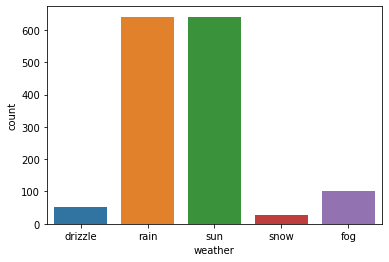

In [11]:
sns.countplot("weather",data=df)


In [42]:
#Converting the date to datetime type
df.date = pd.to_datetime(df.date)

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           1461 non-null   datetime64[ns]
 1   precipitation  1461 non-null   float64       
 2   temp_max       1461 non-null   float64       
 3   temp_min       1461 non-null   float64       
 4   wind           1461 non-null   float64       
 5   weather        1461 non-null   object        
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 68.6+ KB


## Continous Data

In [58]:
df.describe()

,precipitation,temp_max,temp_min,wind
count,1461.000000,1461.000000,1461.000000,1461.000000
mean,3.029432,16.439083,8.234771,3.241136
std,6.680194,7.349758,5.023004,1.437825
min,0.000000,-1.600000,-7.100000,0.400000
25%,0.000000,10.600000,4.400000,2.200000
50%,0.000000,15.600000,8.300000,3.000000
75%,2.800000,22.200000,12.200000,4.000000
max,55.900000,35.600000,18.300000,9.500000


<Axes: xlabel='wind', ylabel='Count'>

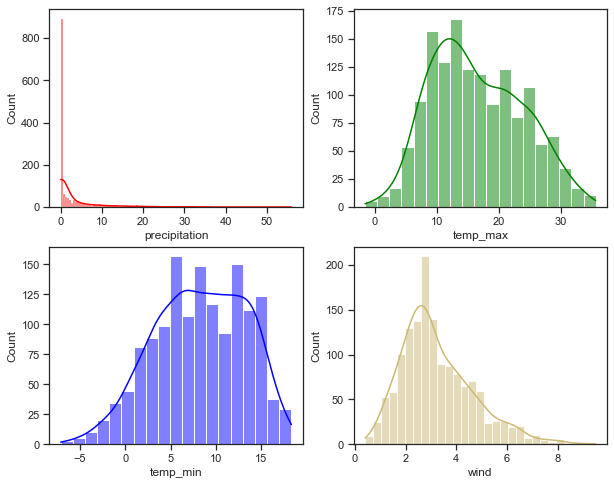

In [81]:
sns.set(style='ticks')
fig,axs = plt.subplots(2,2, figsize = (10,8))
sns.histplot(data= df, x ='precipitation', kde = True, ax= axs[0,0], color ='red')
sns.histplot(data= df, x ='temp_max', kde = True, ax= axs[0,1], color ='green')
sns.histplot(data= df, x ='temp_min', kde = True, ax= axs[1,0], color ='blue')
sns.histplot(data= df, x ='wind', kde = True, ax= axs[1,1], color ='y')


## Finding Outliers

<Axes: xlabel='wind'>

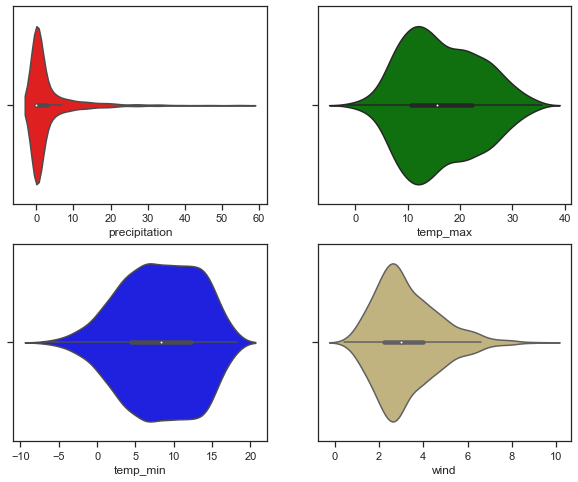

In [80]:
sns.set(style="ticks")
fig,axs=plt.subplots(2,2,figsize=(10,8))
sns.violinplot(data=df,x="precipitation",kde=True,ax=axs[0,0],color='red')
sns.violinplot(data=df,x="temp_max",kde=True,ax=axs[0,1],color='green')
sns.violinplot(data=df,x="temp_min",kde=True,ax=axs[1,0],color='blue')
sns.violinplot(data=df,x="wind",kde=True,ax=axs[1,1],color='y')

In [ ]:
#rain and wind are positively skewed.

<Axes: xlabel='wind'>

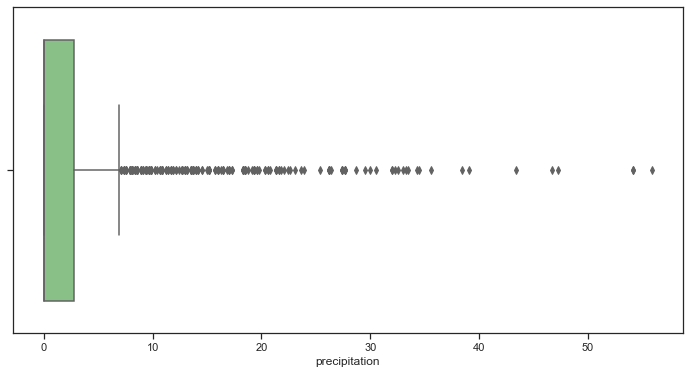

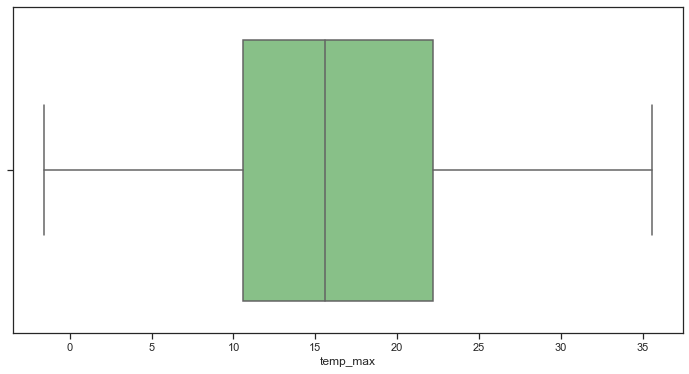

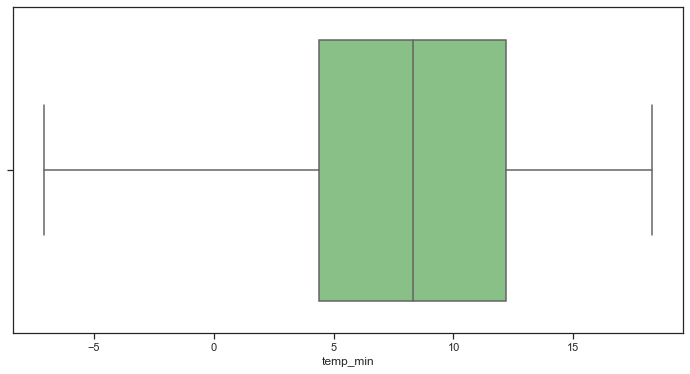

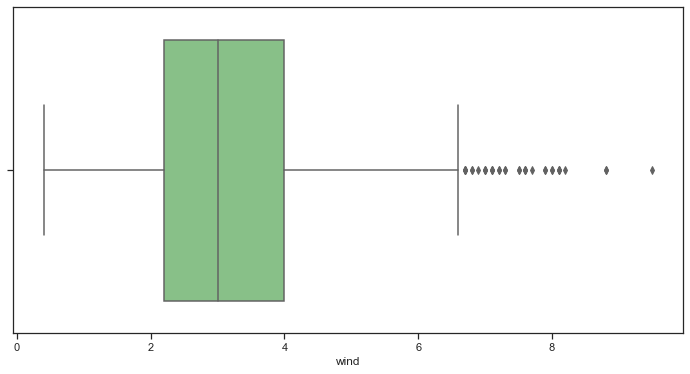

In [104]:
#Let's use boxplot to see the outliers
plt.figure(figsize=(12,6))
sns.boxplot("precipitation",data=df,palette="Accent")

plt.figure(figsize=(12,6))
sns.boxplot("temp_max",data=df,palette="Accent")

plt.figure(figsize=(12,6))
sns.boxplot("temp_min",data=df,palette="Accent")

plt.figure(figsize=(12,6))
sns.boxplot("wind",data=df,palette="Accent")

We can see that precipitation has lots of outliers. 

<Axes: xlabel='precipitation', ylabel='weather'>

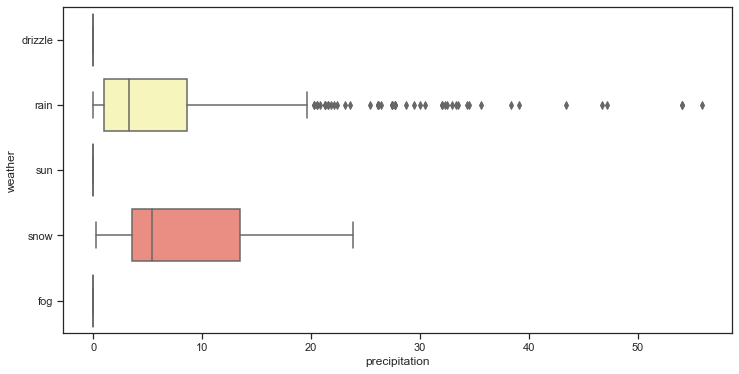

In [105]:
#Let's look at precipitation outliers per weather condition.
plt.figure(figsize=(12,6))
sns.boxplot("precipitation","weather",data=df,palette="Set3")

We see that the rain contition has many positive outliers. 

<Axes: xlabel='temp_max', ylabel='weather'>

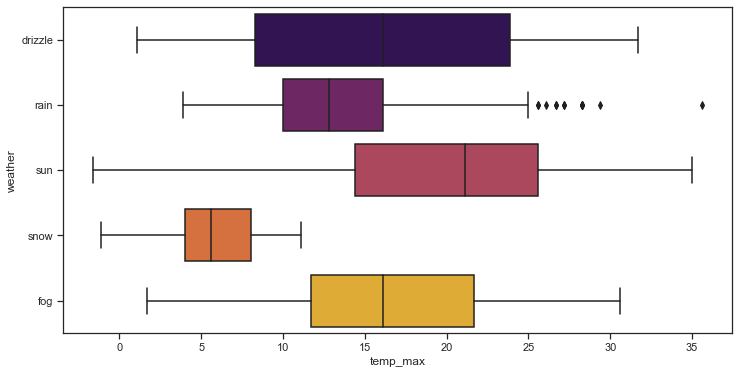

In [111]:
#Let's look at temp_max outliers per weather condition.
plt.figure(figsize=(12,6))
sns.boxplot("temp_max","weather",data=df,palette="inferno")

<Axes: xlabel='temp_min', ylabel='weather'>

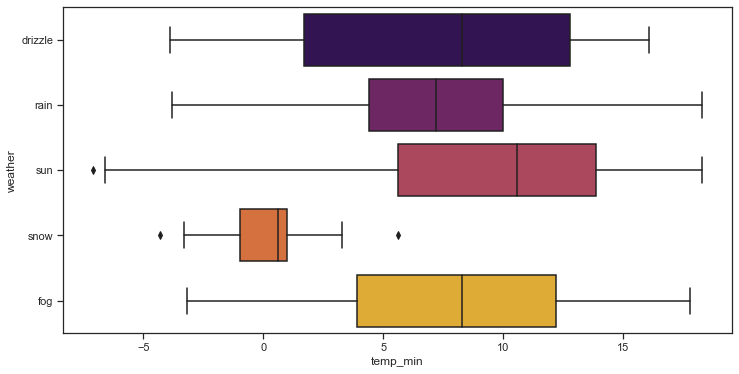

In [112]:
#Let's look at temp_min outliers per weather condition.
plt.figure(figsize=(12,6))
sns.boxplot("temp_min","weather",data=df,palette="inferno")

We that we both positive and negative temp_min outliers in snow.

<Axes: xlabel='wind', ylabel='weather'>

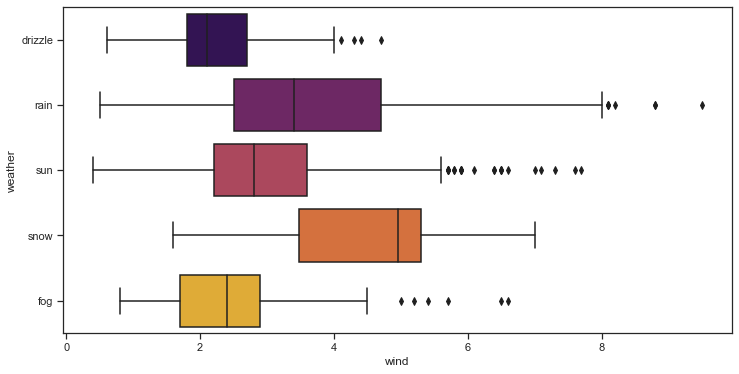

In [113]:
#Let's look at wind outliers per weather condition.
plt.figure(figsize=(12,6))
sns.boxplot("wind","weather",data=df,palette="inferno")

We see that wind in all weather condition hass some positve outliers. 

## Correlation 

<Axes: >

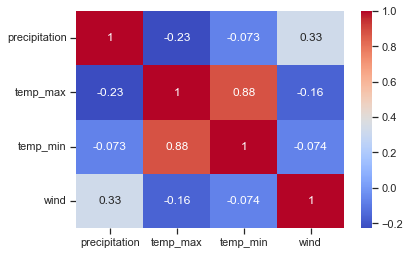

In [119]:
sns.heatmap(df.corr(), annot = True, cmap = 'coolwarm')

There is a correlation between min_temp and max_temp. 
Also, there is a positive correlation between wind and precipitation.

<Axes: xlabel='temp_max'>

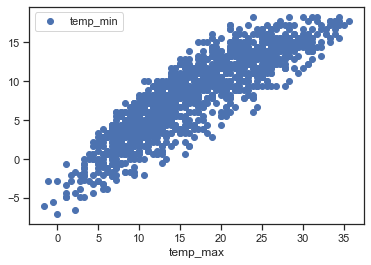

In [121]:
#Correlation betweem max and min tempreture. 
df.plot('temp_max','temp_min', style ='o')

<Axes: xlabel='wind'>

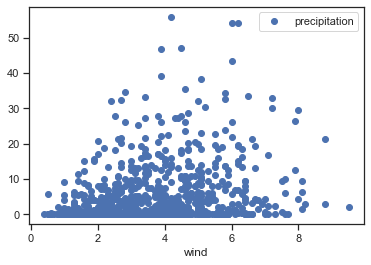

In [122]:
#Correlation betweem wind and min precipitation. 
df.plot('wind','precipitation', style ='o')

In [127]:

print("Pearson correlation:",df["wind"].corr(df["precipitation"]))
print("T Test and P value:",stats.ttest_ind(df["wind"],df["precipitation"]))

Pearson correlation: 0.3280450899352919
T Test and P value: Ttest_indResult(statistic=1.184218948731421, pvalue=0.23642278786502824)


The correlation between wind and precipitation is statistically significant. 

Pearson correlation: -0.22855481643297046
T Test and P value: Ttest_indResult(statistic=-51.60685279531918, pvalue=0.0)


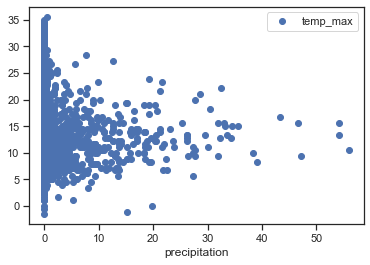

In [129]:
df.plot("precipitation","temp_max",style='o') 
print("Pearson correlation:",df["precipitation"].corr(df["temp_max"]))
print("T Test and P value:",stats.ttest_ind(df["precipitation"],df["temp_max"]))

The correlation between precipitation and temp_max is not statistically significant.

Pearson correlation: -0.16485663487495486
T Test and P value: Ttest_indResult(statistic=-67.3601643301846, pvalue=0.0)


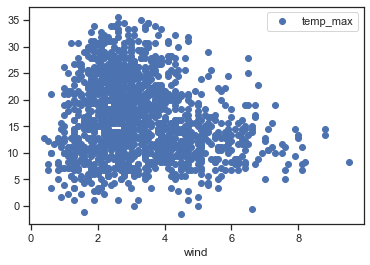

In [130]:
df.plot("wind","temp_max",style='o') 
print("Pearson correlation:",df["wind"].corr(df["temp_max"]))
print("T Test and P value:",stats.ttest_ind(df["wind"],df["temp_max"]))

Pearson correlation: -0.07418522537325307
T Test and P value: Ttest_indResult(statistic=-36.53231095766745, pvalue=5.5513211308427593e-241)


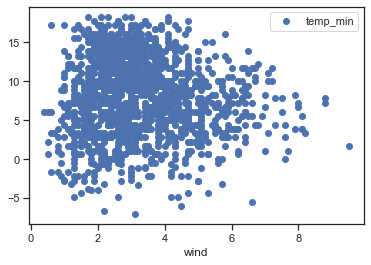

In [131]:
df.plot("wind","temp_min",style='o') 
print("Pearson correlation:",df["wind"].corr(df["temp_min"]))
print("T Test and P value:",stats.ttest_ind(df["wind"],df["temp_min"]))

The result of T test and P value of 0 indicates that the Null hypothesis in the corresponding columns is rejected and the columns are Statistically significant.